In [63]:
import numpy as np
import os, h5py
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, Activation, LeakyReLU, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

(600, 64, 64) (600, 1)
(150, 64, 64) (150, 1)


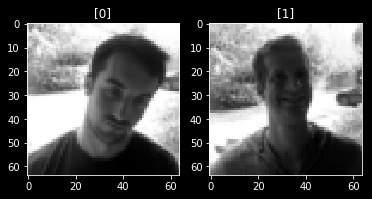

In [105]:
base_path = 'dataset'

x_train = np.load(os.path.join(base_path, 'x_train.npy'))
y_train = np.load(os.path.join(base_path, 'y_train.npy'))
x_test = np.load(os.path.join(base_path, 'x_test.npy'))
y_test = np.load(os.path.join(base_path, 'y_test.npy'))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

plt.subplot(1, 2, 1)
plt.title(y_train[0])
plt.imshow(x_train[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title(y_train[1])
plt.imshow(x_train[1], cmap='gray')

In [106]:
x_train = x_train.reshape((-1, 64, 64, 1))
x_test = x_test.reshape((-1, 64, 64, 1))

train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.8, 1.1],
    rotation_range=15.,
    channel_shift_range=25,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
)

train_batch_gen = train_datagen.flow(x_train, y_train, batch_size=16, shuffle=True)
test_batch_gen = test_datagen.flow(x_test, y_test, batch_size=16, shuffle=False)

In [107]:
inputs = Input(shape=(64, 64, 1))

net = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(units=64)(net)
net = Activation('relu')(net)

net = Dense(units=1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4194368   
_________________________________________________________________
activation_43 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
__________

In [108]:
model.fit_generator(
    train_batch_gen,
    epochs=20,
    validation_data=test_batch_gen,
    callbacks=[
        ModelCheckpoint('models/happy.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/20
38/38 [==============================] - 5s 132ms/step - loss: 0.9617 - acc: 0.6102 - val_loss: 0.6092 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to models/happy.h5
Epoch 2/20
38/38 [==============================] - 3s 88ms/step - loss: 0.5790 - acc: 0.6809 - val_loss: 0.5997 - val_acc: 0.6333

Epoch 00002: val_acc did not improve from 0.66667
Epoch 3/20
38/38 [==============================] - 3s 85ms/step - loss: 0.5356 - acc: 0.7468 - val_loss: 0.5088 - val_acc: 0.7000

Epoch 00003: val_acc improved from 0.66667 to 0.70000, saving model to models/happy.h5
Epoch 4/20
38/38 [==============================] - 3s 84ms/step - loss: 0.5402 - acc: 0.7187 - val_loss: 0.5543 - val_acc: 0.6933

Epoch 00004: val_acc did not improve from 0.70000
Epoch 5/20
38/38 [==============================] - 3s 84ms/step - loss: 0.4948 - acc: 0.7599 - val_loss: 0.4883 - val_acc: 0.7333

Epoch 00005: val_acc improved from 0.70000 to 0.73333, saving model 

In [109]:
x_test_input = x_test.copy().astype(np.float64)
x_test_input -= np.mean(x_test, keepdims=True)
x_test_input /= (np.std(x_test, keepdims=True) + 1e-6)

y_pred = model.predict(x_test_input)

y_pred_logical = (y_pred > 0.5).astype(np.int)

test acc: 0.9


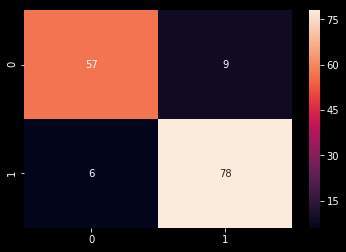

In [110]:
print ('test acc: %s' % accuracy_score(y_test, y_pred_logical))

cm = confusion_matrix(y_test, y_pred_logical)
sns.heatmap(cm, annot=True)